In [ ]:
from google.colab import files

In [ ]:
!pip install split-folders # This library is used to split the Image Dataset into Train and Val folders

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/IACV.zip' #Unzipping the Data

Streaming output truncated to the last 5000 lines.
  inflating: IACV/sketch/giraffe/n02439033_15936-4.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_15936-4.png  
  inflating: IACV/sketch/giraffe/n02439033_10491-2.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_10491-2.png  
  inflating: IACV/sketch/giraffe/n02439033_10164-6.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_10164-6.png  
  inflating: IACV/sketch/giraffe/n02439033_10803-2.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_10803-2.png  
  inflating: IACV/sketch/giraffe/n02439033_14600-1.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_14600-1.png  
  inflating: IACV/sketch/giraffe/n02439033_14724-5.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_14724-5.png  
  inflating: IACV/sketch/giraffe/n02439033_14724-1.png  
  inflating: __MACOSX/IACV/sketch/giraffe/._n02439033_14724-1.png  
  inflating: IACV/sketch/giraffe/n02439033_2486-4.png  
  inflating: __MAC

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/IACV/photo', output="output", seed=1337, ratio=(.8, 0.2)) # The Image Dataset is divided into Train and Val in 80-20 split.

Copying files: 1670 files [00:00, 7611.66 files/s]


In [ ]:
import torchvision
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from glob import glob
import random
from PIL import Image
import numpy as np
import torch.nn as nn
from torchvision import models
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,train_path,val_path,sketch_path,transforms,mode='train'):
    super(CustomDataset,self).__init__()
    self.mode=mode
    self.train_path=train_path   # The Train_path is the path to the train folder in Source Sample
    self.val_path=val_path.      # The Val_path is the path to the val folder in Source Sample
    self.sketch_path=sketch_path # The path to the sketch folder
    self.transforms=transforms   #Transforms applied to convert PIL Image to Tensor format

  def __len__(self):

    # If the mode given is Train then we return the length of the Train Folder and The Sketch folder
      if self.mode=='train':
        len1=0
        for root, dirs, files in os.walk(self.train_path):
            for file in files:    
                if file.endswith('.jpg'):
                    len1 += 1
        len2=0
        for root, dirs, files in os.walk(self.sketch_path):
          for file in files:    
              if file.endswith('.jpg'):
                  len2 += 1
        return (len1+len2)

    # Else the length of the Val folder is returned
      len1=0
      for root, dirs, files in os.walk(self.val_path):
        for file in files:    
          if file.endswith('.jpg'):
            len1 += 1
      return len1

  def __getitem__(self,idx):

    #We randomly select a category from the list of categories
    class_list=['dog','elephant','giraffe','guitar','horse','house','person']
    class_name=random.choice(class_list)

    #The label is is the index of the category within the list.

    label=class_list.index(class_name)

    #If the mode is train we return the sketch_img,Train_img and the label associated.

    if self.mode=='train':
      class_train_path=os.path.join(self.train_path,class_name+"/")
      class_sketch_path=os.path.join(self.sketch_path,class_name+"/")
      train_img_path=class_train_path+random.choice(os.listdir(class_train_path))
      sketch_img_path=class_sketch_path+random.choice(os.listdir(class_sketch_path))
      train_img=np.array(Image.open(train_img_path))
      sketch_img=np.array(Image.open(sketch_img_path))
      if self.transforms:
        train_img=self.transforms(train_img)
        sketch_img=self.transforms(sketch_img)
        return train_img,sketch_img,label

    #Else we return the Val_img and the Label associated.
    class_val_path=os.path.join(self.val_path,class_name+"/")
    val_img_path=class_val_path+random.choice(os.listdir(class_val_path))
    val_img=np.array(Image.open(val_img_path))
    if self.transforms:
      val_img=self.transforms(val_img)
    return val_img,label



In [ ]:
import torchvision.transforms as transforms
transforms=transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((256,256)),])

In [ ]:
train_ds=CustomDataset('/content/output/train','/content/output/val','/content/IACV/sketch',transforms)

In [ ]:
train_dl=DataLoader(train_ds,batch_size=32,shuffle=True)

In [ ]:
def my_loss(loss_fn,train_outputs,train_labels,sketch_outputs):
  # Loss 1 is the standard cross-entropy for the train_img and its outputs.
  loss1=loss_fn(train_outputs,train_labels)

  #Sketch_prob_outputs give us the softmax outputs (probabilities)

  sketch_prob_outputs=torch.exp(sketch_outputs)/(torch.sum(torch.exp(sketch_outputs),axis=0))

  #Sigma_x contains the highest probability values for a sample.
  sigma_x=torch.max(sketch_prob_outputs,axis=1)[0]

  #Classes contain the categories associated with the highest probability value.
  classes=torch.max(sketch_prob_outputs,axis=1)[1]

  #Checks whether the sigma_x values are greater than or equal to 0.95
  weighted_bool=torch.ge(sigma_x,0.95)

  #loss 2 is calculated using the weighted formula
  loss2=0.0
  for i in range(weighted_bool.shape[0]):
    if weighted_bool[i]:
      loss2+=(sigma_x[i]*sigma_x[i])

  #Mean value of loss2 is considered across all the batches.
  loss2=loss2/(weighted_bool.shape[0])

  #Entropy loss is calculated for the sketch_img and its outputs
  sketch_entropy=-1.0*(torch.log(sketch_prob_outputs)*sketch_prob_outputs)
  sketch_entropy=torch.sum(sketch_entropy,axis=0)

  #Mean Value is calculated across all the batches
  loss3=sketch_entropy.mean()
  return classes,loss1,loss2,loss3

# **MODEL is initialised with a pretrained RESNET-18 as the backbone**

In [ ]:
class IACV(nn.Module):
  def __init__(self,num_outputs):
    super(IACV,self).__init__()
    self.model=models.resnet18(pretrained=True)
    for params in self.model.parameters():
      params.requires_grad=False
    self.model.fc=nn.Linear(512,num_outputs)

  def forward(self,train,sketch):
    train=self.model(train)
    sketch=self.model(sketch)
    return train,sketch
  

In [ ]:
model=IACV(7)


In [ ]:
opt=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
loss_fn=nn.CrossEntropyLoss()

In [ ]:
val_ds=CustomDataset('/content/output/train','/content/output/val','/content/IACV/sketch',transforms,'val') #Validation dataset

In [ ]:
val_dl=DataLoader(val_ds,batch_size=64,shuffle=False) #Validation dataloader

In [ ]:
accuracy_list_sketch=[]
accuracy_list_val=[]
mean_loss1_list=[] #to calculate the mean loss1 values
mean_loss2_list=[] #to calculate the mean loss2 values
mean_loss3_list=[] #Ro calculate the mean loss3 values

#$ epochs are considered, can be trained with higher epochs for better accuracy

for i in range(4):
  correct=0
  total=0
  total_val=0
  correct_val=0
  loss_1_list=[]
  loss_2_list=[]
  loss_3_list=[]
  for x,y,labels in train_dl:
    model.train()
    opt.zero_grad()
    train_outputs,sketch_outputs=model(x,y)
    classes,loss1,loss2,loss3=my_loss(loss_fn,train_outputs,labels,sketch_outputs)

    #cumulative loss is calculated using the formula
    
    loss=loss1+2.0*loss2+3.0*loss3
    loss.backward()
    opt.step()
    correct+=(classes==labels).sum().item()
    total+=labels.size(0)
    loss_1_list.append(loss1)
    loss_2_list.append(loss2)
    loss_3_list.append(loss3)

  with torch.no_grad():
    model.eval()
    for val_img,labels in val_dl:
      val_outputs,_=model(val_img,val_img)
      _, preds = torch.max(val_outputs.data, 1)
      correct_val+=(preds==labels).sum().item()
      total_val+=labels.size(0)
    
  mean_loss1_list.append(sum(loss_1_list)/len(loss_1_list))
  mean_loss2_list.append(sum(loss_2_list)/len(loss_2_list))
  mean_loss3_list.append(sum(loss_3_list)/len(loss_3_list))
  accuracy_list_sketch.append(correct*100/total)
  accuracy_list_val.append(correct_val*100/total_val)

# **We now Plot the accuracy scores of the validation data and the unlabelled sketch data with respect to the Epochs**

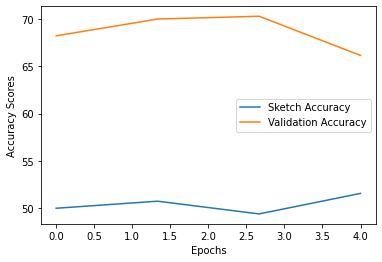

In [ ]:
plt.plot(np.linspace(0,4,4),accuracy_list_sketch,label='Sketch Accuracy')
plt.plot(np.linspace(0,4,4),accuracy_list_val,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Scores')
plt.legend()

# **Plotting of the mean loss values of the three loss components with respect to Epochs**

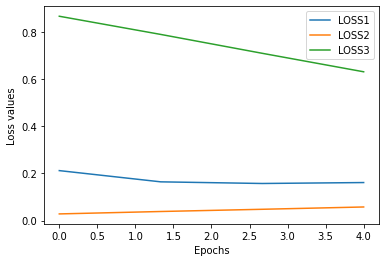

In [ ]:
plt.plot(np.linspace(0,4,4),mean_loss1_list,label='LOSS1')
plt.plot(np.linspace(0,4,4),mean_loss2_list,label='LOSS2')
plt.plot(np.linspace(0,4,4),mean_loss3_list,label='LOSS3')
plt.xlabel('Epochs')
plt.ylabel('Loss values')
plt.legend()